In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import ase
import ase.io
import ase.visualize
import sys
from pathlib import Path
from dscribe.descriptors import CoulombMatrix, SOAP

In [2]:
project_path = str(Path.cwd().parent.parent.parent)
if project_path not in sys.path:
    sys.path.append(project_path)
import sisclab22p6.data
filepath_data = "../../../data/jij"
filename_table = "d_block_magnetic_data_modified.csv"
filename_structures = "dimer_clusters.extxyz"
table = sisclab22p6.data.load_jij_data(filepath = filepath_data, 
                                       filename_table=filename_table, 
                                       filename_structures=filename_structures)

Loaded Number samples: 1730, 1730.


In [3]:
table = table.drop_duplicates('workchain_label')
num_samples = table.shape[0]
num_samples_lc = list(reversed([int(num_samples/(2**power)) for power in range(5)]))

# DESCRIPTOR USED: COULOMB MATRIX

In [4]:
cm = CoulombMatrix(
    n_atoms_max=22,
    permutation='sorted_l2'
)
cm_mae = np.zeros((len(num_samples_lc), 3))
cm_r2 = np.zeros((len(num_samples_lc), 3))

In [5]:
for num_samples in num_samples_lc:
    for i in range(3):
        table_lr = table.sample(num_samples)
        structure = table_lr.iloc[:,7]
        sample = []
        for j in structure.index:
            atoms = structure[j]
            sample.append(atoms)  
        coulomb_matrices = cm.create(sample, n_jobs=-1)
        x = coulomb_matrices
        y = np.array(table_lr.iloc[:,8])
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        alpha = np.logspace(-4, -2, 3)
        gamma = np.logspace(-4, -2, 3)
        cv_number = 3
        kernel = 'rbf'
        scoring_function = 'neg_mean_absolute_error' 
        grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                                   [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                                   cv = cv_number, 
                                   scoring = scoring_function,
                                   verbose = 0)
        grid_search.fit(x_train, y_train)
        y_pred = grid_search.predict(x_test)
        cm_mae[num_samples_lc.index(num_samples), i] = (np.abs(y_pred-y_test)).mean()
        cm_r2[num_samples_lc.index(num_samples), i] = r2_score(y_test, y_pred)

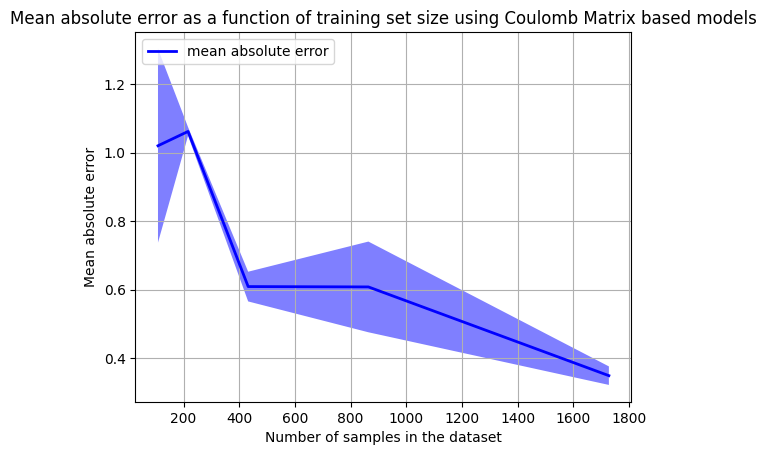

In [6]:
cm_means_mae = cm_mae.mean(axis = 1)
cm_std_mae = cm_mae.std(axis = 1) 
fig, ax = plt.subplots(1)
ax.plot(num_samples_lc, cm_means_mae, lw=2, label='mean absolute error', color='blue')
ax.fill_between(num_samples_lc, cm_means_mae + cm_std_mae, cm_means_mae - cm_std_mae, facecolor='blue', alpha=0.5)
ax.set_title(r'Mean absolute error as a function of training set size using Coulomb Matrix based models')
ax.legend(loc='upper left')
ax.set_xlabel('Number of samples in the dataset')
ax.set_ylabel('Mean absolute error')
ax.grid()

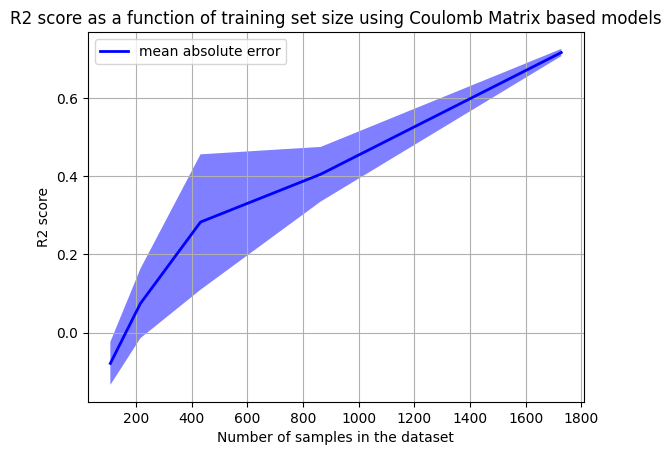

In [7]:
cm_means_r2 = cm_r2.mean(axis = 1)
cm_std_r2 = cm_r2.std(axis = 1) 
fig, ax = plt.subplots(1)
ax.plot(num_samples_lc, cm_means_r2, lw=2, label='mean absolute error', color='blue')
ax.fill_between(num_samples_lc, cm_means_r2 + cm_std_r2, cm_means_r2 - cm_std_r2, facecolor='blue', alpha=0.5)
ax.set_title(r'R2 score as a function of training set size using Coulomb Matrix based models')
ax.legend(loc='upper left')
ax.set_xlabel('Number of samples in the dataset')
ax.set_ylabel('R2 score')
ax.grid()

# DESCRIPTOR USED: CONCATENATED SOAP

In [8]:
n_max = 1
l_max = 2
r_cut = 4.0
sigma = 1.0
# chosen from hyperparameter tuning

structures =  list(table.structure)
samples = structures
species = set(np.concatenate([np.unique(struc.numbers) for struc in structures]))
soap = SOAP(r_cut= r_cut,
            n_max= n_max, 
            l_max= l_max, 
            sigma= sigma, 
            rbf= "gto", 
            weighting= None, 
            crossover= True, 
            average= "off", 
            species= species, 
            periodic= False, 
            sparse= False, 
            dtype= "float64"    
                     )
soap_c_mae = np.zeros((len(num_samples_lc), 3))
soap_c_r2 = np.zeros((len(num_samples_lc), 3))

In [9]:
for num_samples in num_samples_lc:
    for i in range(3):
        table_lr = table.sample(num_samples)
        structures = list(table_lr.structure)
        samples = structures
        positions = [[0,7] for i in range(len(samples))]
        x = soap.create(samples, positions, n_jobs = -1)
        y = np.array(table_lr.iloc[:,8])
        b = []
        for j in range(len(samples)):
            a = np.concatenate((x[j,0],x[j,1]), axis=None)
            b.append(a)
        x = b
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x)
        
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        alpha = np.logspace(-4, -2, 3)
        gamma = np.logspace(-4, -2, 3)
        cv_number = 3
        kernel = 'rbf'
        scoring_function = 'neg_mean_absolute_error' 
        grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                                   [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                                   cv = cv_number, 
                                   scoring = scoring_function,
                                   verbose = 0)
        grid_search.fit(x_train, y_train)
        y_pred = grid_search.predict(x_test)
        soap_c_mae[num_samples_lc.index(num_samples), i] = (np.abs(y_pred-y_test)).mean()
        soap_c_r2[num_samples_lc.index(num_samples), i] = r2_score(y_test, y_pred)

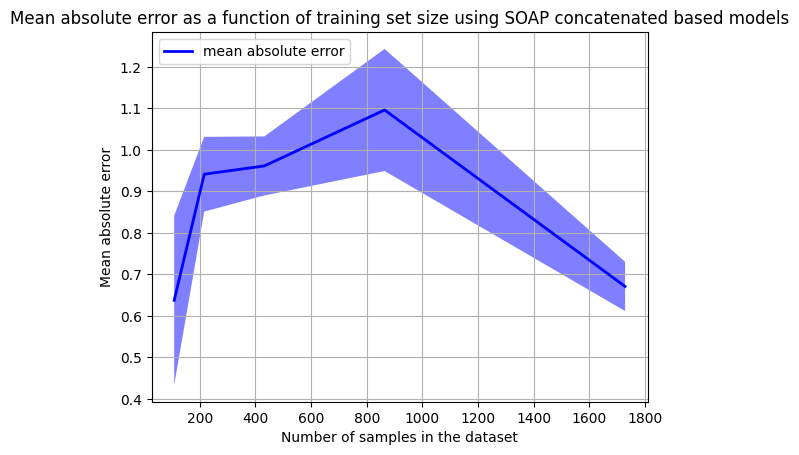

In [10]:
soap_c_means_mae = soap_c_mae.mean(axis = 1)
soap_c_std_mae = soap_c_mae.std(axis = 1) 
fig, ax = plt.subplots(1)
ax.plot(num_samples_lc, soap_c_means_mae, lw=2, label='mean absolute error', color='blue')
ax.fill_between(num_samples_lc, soap_c_means_mae + soap_c_std_mae, soap_c_means_mae - soap_c_std_mae, facecolor='blue', alpha=0.5)
ax.set_title(r'Mean absolute error as a function of training set size using SOAP concatenated based models')
ax.legend(loc='upper left')
ax.set_xlabel('Number of samples in the dataset')
ax.set_ylabel('Mean absolute error')
ax.grid()

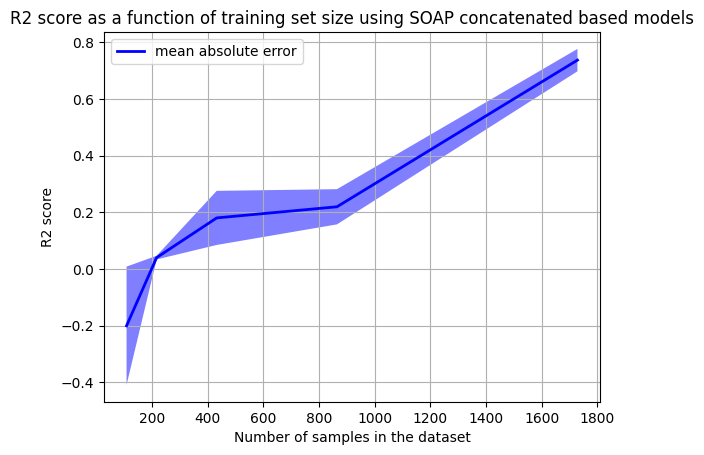

In [11]:
soap_c_means_r2 = soap_c_r2.mean(axis = 1)
soap_c_std_r2 = soap_c_r2.std(axis = 1) 
fig, ax = plt.subplots(1)
ax.plot(num_samples_lc, soap_c_means_r2, lw=2, label='mean absolute error', color='blue')
ax.fill_between(num_samples_lc, soap_c_means_r2 + soap_c_std_r2, soap_c_means_r2 - soap_c_std_r2, facecolor='blue', alpha=0.5)
ax.set_title(r'R2 score as a function of training set size using SOAP concatenated based models')
ax.legend(loc='upper left')
ax.set_xlabel('Number of samples in the dataset')
ax.set_ylabel('R2 score')
ax.grid()

# DESCRIPTOR USED: AVERAGED SOAP

In [12]:
n_max = 1
l_max = 2
r_cut = 4.0
sigma = 1.0
# chosen from hyperparameter tuning

structures =  list(table.structure)
samples = structures
species = set(np.concatenate([np.unique(struc.numbers) for struc in structures]))
soap2 = SOAP(r_cut= r_cut,
             n_max= n_max, 
             l_max= l_max, 
             sigma= sigma, 
             rbf= "gto", 
             weighting= None, 
             crossover= True, 
             average= "inner", 
             species= species, 
             periodic= False, 
             sparse= False, 
             dtype= "float64"    
                     )
soap_a_mae = np.zeros((len(num_samples_lc), 3))
soap_a_r2 = np.zeros((len(num_samples_lc), 3))

In [13]:
for num_samples in num_samples_lc:
    for i in range(3):
        table_lr = table.sample(num_samples)
        structures = list(table_lr.structure)
        samples = structures
        positions = [[0,7] for i in range(len(samples))]
        x = soap2.create(samples, positions, n_jobs = -1)
        y = np.array(table_lr.iloc[:,8])
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
        alpha = np.logspace(-4, -2, 3)
        gamma = np.logspace(-4, -2, 3)
        cv_number = 3
        kernel = 'rbf'
        scoring_function = 'neg_mean_absolute_error' 
        grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                                   [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                                   cv = cv_number, 
                                   scoring = scoring_function,
                                   verbose = 0)
        grid_search.fit(x_train, y_train)
        y_pred = grid_search.predict(x_test)
        soap_a_mae[num_samples_lc.index(num_samples), i] = (np.abs(y_pred-y_test)).mean()
        soap_a_r2[num_samples_lc.index(num_samples), i] = r2_score(y_test, y_pred)

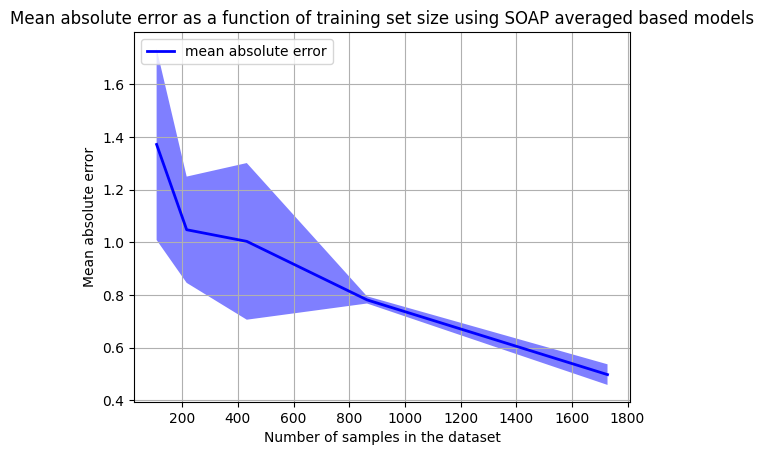

In [14]:
soap_a_means_mae = soap_a_mae.mean(axis = 1)
soap_a_std_mae = soap_a_mae.std(axis = 1) 
fig, ax = plt.subplots(1)
ax.plot(num_samples_lc, soap_a_means_mae, lw=2, label='mean absolute error', color='blue')
ax.fill_between(num_samples_lc, soap_a_means_mae + soap_a_std_mae, soap_a_means_mae - soap_a_std_mae, facecolor='blue', alpha=0.5)
ax.set_title(r'Mean absolute error as a function of training set size using SOAP averaged based models')
ax.legend(loc='upper left')
ax.set_xlabel('Number of samples in the dataset')
ax.set_ylabel('Mean absolute error')
ax.grid()

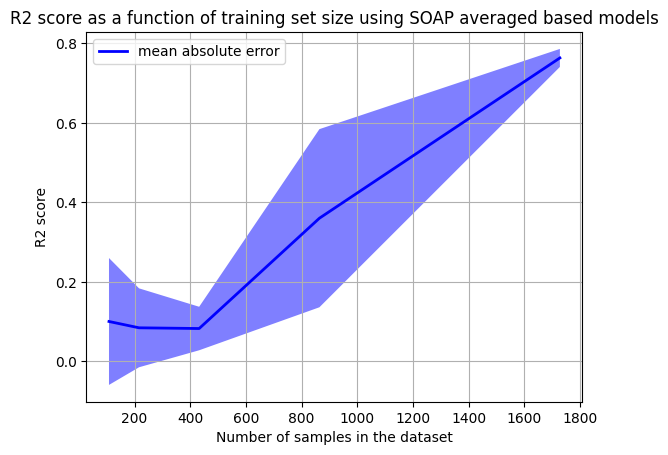

In [28]:
soap_a_means_r2 = soap_a_r2.mean(axis = 1)
soap_a_std_r2 = soap_a_r2.std(axis = 1) 
fig, ax = plt.subplots(1)
ax.plot(num_samples_lc, soap_a_means_r2, lw=2, label='mean absolute error', color='blue')
ax.fill_between(num_samples_lc, soap_a_means_r2 + soap_a_std_r2, soap_a_means_r2 - soap_a_std_r2, facecolor='blue', alpha=0.5)
ax.set_title(r'R2 score as a function of training set size using SOAP averaged based models')
ax.legend(loc='upper left')
ax.set_xlabel('Number of samples in the dataset')
ax.set_ylabel('R2 score')
ax.grid()

# NOT USEFUL

## CM for 0.1 test size

In [16]:
cm_01_mae = np.zeros(3)    
cm_01_r2 = np.zeros(3)    
for i in range(3):
    #from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

    # plt.hist(y_test, bins=100, density=False, alpha=0.5, facecolor='red', label='test set')
    # plt.hist(y_train, bins=100, density=False, alpha=0.5, facecolor='gray', label='training set')
    # plt.xlabel("J")
    # plt.ylabel("Number of molecules")
    # plt.legend()
    # plt.show()
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.kernel_ridge import KernelRidge
    # from sklearn.metrics import r2_score

    alpha = np.logspace(-4, -2, 3)
    gamma = np.logspace(-4, -2, 3)

    cv_number = 3 ## choose into how many parts training set is divided for cross-validation
    kernel = 'rbf' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
    scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                                 # highest scoring value as best, but we want small errors

    ## define settings for grid search routine in scikit-learn with above defined grids as input

    grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                               [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                               cv = cv_number, 
                               scoring = scoring_function,
                               verbose=0)  ## produces detailed output statements of grid search 
                                              # routine so we can see what is computed

    # call the fit function in scikit-learn which fits the Coulomb matrices in the training set 
    # to their corresponding Jij.
    grid_search.fit(x_train, y_train)
    # predicted Jij for all test molecules

    y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                         # of hyperparameters from grid search

    print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

    # do the regression plot
    # plt.plot(y_test, y_pred, 'o')
    # plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
    # plt.xlabel('reference Jij [eV]')
    # plt.ylabel('predicted Jij [eV]')
    # plt.show()
    print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))
    cm_01_mae[i] = (np.abs(y_pred-y_test)).mean()  
    cm_01_r2[i] = r2_score(y_test, y_pred)  

Mean absolute error on test set: 0.283 eV
R^2 score on test set: 0.949
Mean absolute error on test set: 0.448 eV
R^2 score on test set: 0.870
Mean absolute error on test set: 0.344 eV
R^2 score on test set: 0.890


In [17]:
print(cm_01_mae)
print(cm_01_r2)

[0.2827459  0.44779173 0.3438568 ]
[0.94895786 0.87010489 0.88966547]


## CM for 0.15 test size

In [18]:
cm_015_mae = np.zeros(3)    
cm_015_r2 = np.zeros(3)    
for i in range(3):
    #from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

    # plt.hist(y_test, bins=100, density=False, alpha=0.5, facecolor='red', label='test set')
    # plt.hist(y_train, bins=100, density=False, alpha=0.5, facecolor='gray', label='training set')
    # plt.xlabel("J")
    # plt.ylabel("Number of molecules")
    # plt.legend()
    # plt.show()
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.kernel_ridge import KernelRidge
    # from sklearn.metrics import r2_score

    alpha = np.logspace(-4, -2, 3)
    gamma = np.logspace(-4, -2, 3)

    cv_number = 3 ## choose into how many parts training set is divided for cross-validation
    kernel = 'rbf' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
    scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                                 # highest scoring value as best, but we want small errors

    ## define settings for grid search routine in scikit-learn with above defined grids as input

    grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                               [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                               cv = cv_number, 
                               scoring = scoring_function,
                               verbose=0)  ## produces detailed output statements of grid search 
                                              # routine so we can see what is computed

    # call the fit function in scikit-learn which fits the Coulomb matrices in the training set 
    # to their corresponding Jij.
    grid_search.fit(x_train, y_train)
    # predicted Jij for all test molecules

    y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                         # of hyperparameters from grid search

    #print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

    # do the regression plot
    # plt.plot(y_test, y_pred, 'o')
    # plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
    # plt.xlabel('reference Jij [eV]')
    # plt.ylabel('predicted Jij [eV]')
    # plt.show()
    #print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))
    cm_015_mae[i] = (np.abs(y_pred-y_test)).mean()  
    cm_015_r2[i] = r2_score(y_test, y_pred)  

In [19]:
print(cm_015_mae)
print(cm_015_r2)

[0.3055903  0.49342103 0.4957535 ]
[0.8734673  0.75337161 0.80282958]


## CM for 0.2 test size

In [20]:
cm_02_mae = np.zeros(3)    
cm_02_r2 = np.zeros(3)    
for i in range(3):
    #from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # plt.hist(y_test, bins=100, density=False, alpha=0.5, facecolor='red', label='test set')
    # plt.hist(y_train, bins=100, density=False, alpha=0.5, facecolor='gray', label='training set')
    # plt.xlabel("J")
    # plt.ylabel("Number of molecules")
    # plt.legend()
    # plt.show()
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.kernel_ridge import KernelRidge
    # from sklearn.metrics import r2_score

    alpha = np.logspace(-4, -2, 3)
    gamma = np.logspace(-4, -2, 3)

    cv_number = 3 ## choose into how many parts training set is divided for cross-validation
    kernel = 'rbf' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
    scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                                 # highest scoring value as best, but we want small errors

    ## define settings for grid search routine in scikit-learn with above defined grids as input

    grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                               [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                               cv = cv_number, 
                               scoring = scoring_function,
                               verbose=0)  ## produces detailed output statements of grid search 
                                              # routine so we can see what is computed

    # call the fit function in scikit-learn which fits the Coulomb matrices in the training set 
    # to their corresponding Jij.
    grid_search.fit(x_train, y_train)
    # predicted Jij for all test molecules

    y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                         # of hyperparameters from grid search

    #print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

    # do the regression plot
    # plt.plot(y_test, y_pred, 'o')
    # plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
    # plt.xlabel('reference Jij [eV]')
    # plt.ylabel('predicted Jij [eV]')
    # plt.show()
    #print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))
    cm_02_mae[i] = (np.abs(y_pred-y_test)).mean()  
    cm_02_r2[i] = r2_score(y_test, y_pred) 

In [21]:
print(cm_02_mae)
print(cm_02_r2)

[0.4276488  0.49036234 0.54454866]
[0.914604  0.7575424 0.668085 ]


## CM for 0.25 test size

In [22]:
cm_025_mae = np.zeros(3)    
cm_025_r2 = np.zeros(3)    
for i in range(3):
    #from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

    # plt.hist(y_test, bins=100, density=False, alpha=0.5, facecolor='red', label='test set')
    # plt.hist(y_train, bins=100, density=False, alpha=0.5, facecolor='gray', label='training set')
    # plt.xlabel("J")
    # plt.ylabel("Number of molecules")
    # plt.legend()
    # plt.show()
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.kernel_ridge import KernelRidge
    # from sklearn.metrics import r2_score

    alpha = np.logspace(-4, -2, 3)
    gamma = np.logspace(-4, -2, 3)

    cv_number = 3 ## choose into how many parts training set is divided for cross-validation
    kernel = 'rbf' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
    scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                                 # highest scoring value as best, but we want small errors

    ## define settings for grid search routine in scikit-learn with above defined grids as input

    grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                               [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                               cv = cv_number, 
                               scoring = scoring_function,
                               verbose=0)  ## produces detailed output statements of grid search 
                                              # routine so we can see what is computed

    # call the fit function in scikit-learn which fits the Coulomb matrices in the training set 
    # to their corresponding Jij.
    grid_search.fit(x_train, y_train)
    # predicted Jij for all test molecules

    y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                         # of hyperparameters from grid search

    #print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

    # do the regression plot
    # plt.plot(y_test, y_pred, 'o')
    # plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
    # plt.xlabel('reference Jij [eV]')
    # plt.ylabel('predicted Jij [eV]')
    # plt.show()
    #print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))
    cm_025_mae[i] = (np.abs(y_pred-y_test)).mean()  
    cm_025_r2[i] = r2_score(y_test, y_pred) 

In [23]:
print(cm_025_mae)
print(cm_025_r2)

[0.58718024 0.50031449 0.52734326]
[0.7086027  0.7951848  0.80957461]


## CM for 0.3 test size

In [24]:
cm_03_mae = np.zeros(3)    
cm_03_r2 = np.zeros(3)    
for i in range(3):
    #from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    # plt.hist(y_test, bins=100, density=False, alpha=0.5, facecolor='red', label='test set')
    # plt.hist(y_train, bins=100, density=False, alpha=0.5, facecolor='gray', label='training set')
    # plt.xlabel("J")
    # plt.ylabel("Number of molecules")
    # plt.legend()
    # plt.show()
    # from sklearn.model_selection import GridSearchCV
    # from sklearn.kernel_ridge import KernelRidge
    # from sklearn.metrics import r2_score

    alpha = np.logspace(-4, -2, 3)
    gamma = np.logspace(-4, -2, 3)

    cv_number = 3 ## choose into how many parts training set is divided for cross-validation
    kernel = 'rbf' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
    scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                                 # highest scoring value as best, but we want small errors

    ## define settings for grid search routine in scikit-learn with above defined grids as input

    grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                               [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                               cv = cv_number, 
                               scoring = scoring_function,
                               verbose=0)  ## produces detailed output statements of grid search 
                                              # routine so we can see what is computed

    # call the fit function in scikit-learn which fits the Coulomb matrices in the training set 
    # to their corresponding Jij.
    grid_search.fit(x_train, y_train)
    # predicted Jij for all test molecules

    y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                         # of hyperparameters from grid search

    #print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

    # do the regression plot
    # plt.plot(y_test, y_pred, 'o')
    # plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
    # plt.xlabel('reference Jij [eV]')
    # plt.ylabel('predicted Jij [eV]')
    # plt.show()
    #print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))
    cm_03_mae[i] = (np.abs(y_pred-y_test)).mean()  
    cm_03_r2[i] = r2_score(y_test, y_pred) 

In [25]:
print(cm_03_mae)
print(cm_03_r2)

[0.53749981 0.52105274 0.5465845 ]
[0.73957197 0.73952892 0.77888544]


[0.1  0.15 0.2  0.25 0.3 ]


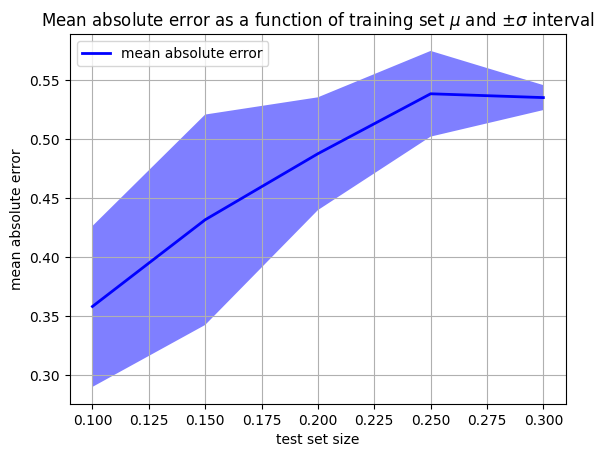

In [26]:
means = np.array((cm_01_mae.mean(), cm_015_mae.mean(), cm_02_mae.mean(), cm_025_mae.mean(), cm_03_mae.mean()))
stds = np.array((cm_01_mae.std(), cm_015_mae.std(), cm_02_mae.std(), cm_025_mae.std(), cm_03_mae.std()))
x = np.array((0.1, 0.15, 0.2, 0.25, 0.3))
print(x)
fig, ax = plt.subplots(1)
ax.plot(x, means, lw=2, label='mean absolute error', color='blue')
ax.fill_between(x, means+stds, means-stds, facecolor='blue', alpha=0.5)
ax.set_title(r'Mean absolute error as a function of training set $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper left')
ax.set_xlabel('test set size')
ax.set_ylabel('mean absolute error')
ax.grid()

[0.1  0.15 0.2  0.25 0.3 ]


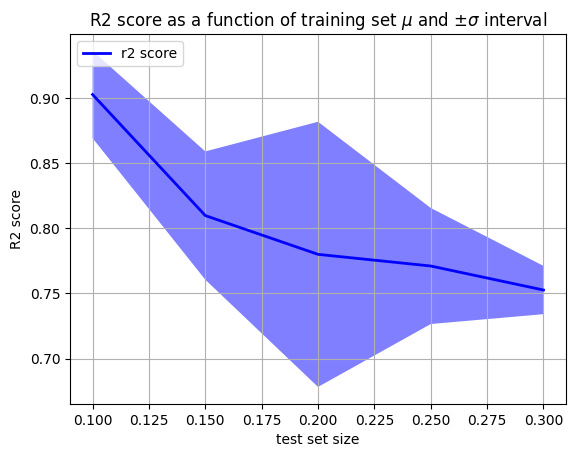

In [27]:
means = np.array((cm_01_r2.mean(), cm_015_r2.mean(), cm_02_r2.mean(), cm_025_r2.mean(), cm_03_r2.mean()))
stds = np.array((cm_01_r2.std(), cm_015_r2.std(), cm_02_r2.std(), cm_025_r2.std(), cm_03_r2.std()))
x = np.array((0.1, 0.15, 0.2, 0.25, 0.3))
print(x)
fig, ax = plt.subplots(1)
ax.plot(x, means, lw=2, label='r2 score', color='blue')
ax.fill_between(x, means+stds, means-stds, facecolor='blue', alpha=0.5)
ax.set_title(r'R2 score as a function of training set $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper left')
ax.set_xlabel('test set size')
ax.set_ylabel('R2 score')
ax.grid()